In [9]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [10]:
data = pd.read_json("train.json")[["request_text","requester_received_pizza"]]
print data.shape
train_data = data[:3500]["request_text"]
train_labels = data[:3500]["requester_received_pizza"]
dev_data = data[3501:]["request_text"]
dev_labels = data[3501:]["requester_received_pizza"]

(4040, 2)


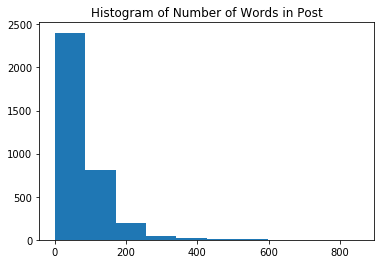

,# of Words
count,3500.000000
mean,78.094571
std,73.007565
min,0.000000
25%,35.000000
50%,59.000000
75%,97.250000
max,854.000000


In [28]:
post_lengths = []
for post in train_data:
    post_lengths.append(len(post.split()))
post_length_np = np.array(post_lengths)
plt.hist(post_length_np)
plt.title("Histogram of Number of Words in Post")
plt.show()
pd.DataFrame(data = {'# of Words': post_length_np}).describe()

In [4]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def better_preprocessor(s):
    message = s.lower()
    message = re.sub(r"[^a-z]", " ", message)
    message = re.sub(r"[-]*", "", message)
    return message

def stemming_tokenizer(str_input):
    words = re.sub(r"[^a-z]", " ", str_input).split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [5]:
cv = TfidfVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
transformer = cv.fit_transform(train_data)
classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570


In [16]:
# Method to search for an optimal k for a K Nearest Neighbor vectorizer
def knn_optimal_k(vectorizer,train_data,train_labels,dev_data,dev_labels, \
                      k_values=np.arange(1,50)):
    train_data_vectorized = vectorizer.fit_transform(train_data)
    dev_data_vectorized = vectorizer.transform(dev_data)
    
    # Fit K-Nearest Neighbor
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_data_vectorized,train_labels)
        accuracy = knn.score(dev_data_vectorized,dev_labels)
        accuracies.append(accuracy)
        #print knn
        #print "accuracy = ",accuracy

    plt.plot(k_values,accuracies)
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title('Accuracy for values of k in KNN')
    plt.show()    
        
    optimal_k = k_values[accuracies.index(max(accuracies))]
    print "optimal k = ",optimal_k
    
    knn = KNeighborsClassifier(n_neighbors=optimal_k)
    knn.fit(train_data_vectorized,train_labels)
    y_pred = knn.predict(dev_data_vectorized)
    print knn
    print"    accuracy  = %2.3f" % (max(accuracies))
    print"    f1 scores = ", metrics.f1_score(dev_labels, y_pred,average=None)
    print    

#### Application of the search for optimal k for our current vectorizer

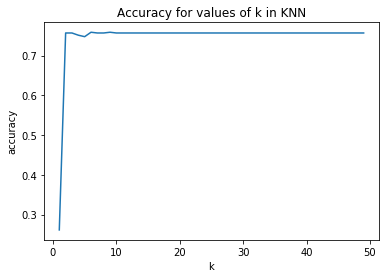

optimal k =  6
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
    accuracy  = 0.759
    f1 scores =  [0.86228814 0.02985075]



In [17]:
knn_optimal_k(cv,train_data,train_labels,dev_data,dev_labels)

In [26]:
def log_res_optimal_C(vectorizer,train_data,train_labels,dev_data,dev_labels, \
                      C_list=[0.001, 0.01, 0.1, 0.5, 1.0]):
    train_data_vectorized = vectorizer.fit_transform(train_data)
    dev_data_vectorized = vectorizer.transform(dev_data)
    
    accuracies = []
    for C in C_list:
        lr = LogisticRegression(C=C).fit(train_data_vectorized,train_labels)
        accuracy = lr.score(dev_data_vectorized,dev_labels)
        accuracies.append(accuracy)
        #print lr
        #print "accuracy =",accuracy
        #print

    plt.plot(C_list,accuracies)
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.title('Accuracy for values of C in Logistic Regression')
    plt.show()
   
    optimal_C = C_list[accuracies.index(max(accuracies))]
    print "optimal C = ",optimal_C
    lr = LogisticRegression(C=optimal_C).fit(train_data_vectorized,train_labels)
    print lr
    print "    accuracy  = ",max(accuracies)
    print

In [49]:
# Name for CountVectorizer and Fit Transform changed to differentiate
# variable names between candidateVectorizers used in other cells
cv = CountVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
cv_transformer = cv.fit_transform(train_data)
classifier = LogisticRegression(C=0.001)
classifier.fit(cv_transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570


In [50]:
print "Number of non-zero elements in fit_transform = ",cv_transformer.nnz
print "Shape of fit transform",cv_transformer.shape
print "0th feature string  = ",cv.get_feature_names()[0]
print "Last feature string = ",cv.get_feature_names()[cv_transformer.shape[1]-1]

Number of non-zero elements in fit_transform =  115517
Shape of fit transform (3500, 8037)
0th feature string  =  aa
Last feature string =  zza


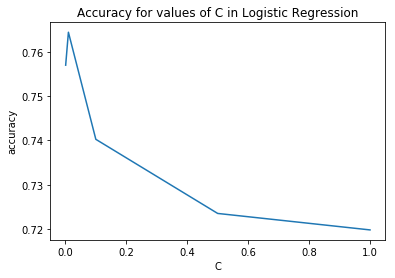

optimal C =  0.01
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    accuracy  =  0.764378478664193



In [51]:
log_res_optimal_C(cv,train_data,train_labels,dev_data,dev_labels)

In [52]:
# Name for CountVectorizer and Fit Transform changed to differentiate
# variable names between candidateVectorizers used in other cells
tfidf = TfidfVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
tfidf_transformer = tfidf.fit_transform(train_data)
classifier = LogisticRegression(C=0.001)
classifier.fit(tfidf_transformer,train_labels)
dev_data_trans = tfidf.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570


In [53]:
print "Number of non-zero elements in fit_transform = ",tfidf_transformer.nnz
print "Shape of fit transform",tfidf_transformer.shape
print "0th feature string  = ",tfidf.get_feature_names()[0]
print "Last feature string = ",tfidf.get_feature_names()[tfidf_transformer.shape[1]-1]

Number of non-zero elements in fit_transform =  115517
Shape of fit transform (3500, 8037)
0th feature string  =  aa
Last feature string =  zza


#### Should the TF-IDF Count Vectorizer have the same shape as the standard Count Vectorizer?

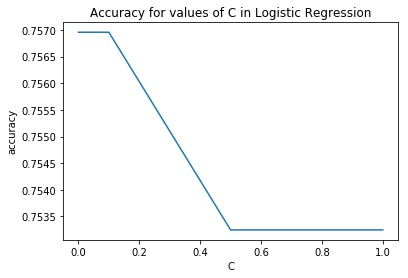

optimal C =  1e-05
LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    accuracy  =  0.7569573283858998



In [31]:
log_res_optimal_C(tfidf,train_data,train_labels,dev_data,dev_labels,[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0])

#### TODO : Check into why C = [0.00001, 0.0001, 0.001, 0.01] have same accuracy

In [90]:
print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)

             precision    recall  f1-score   support

      False       0.76      1.00      0.86       408
       True       0.00      0.00      0.00       131

avg / total       0.57      0.76      0.65       539

